In [11]:
import copy
import os
import numpy as np
import csv
import numpy as np
import argparse
from IPython.display import display

import json
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from set_analyze.my_diff_color import *

from cache_sensitive_names import *

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

cache_type = 'goldencove'
# cache_type = 'goldencove24M'


select_bucket = '32bucket'
if cache_type == 'goldencove24M':
        select_bucket = '64bucket'

select_json = f'/nfs/home/zhangchuanqi/lvna/5g/lazycat-data_proc/set_analyze/conf-json/conf_{cache_type}_tailbm50M.json'

with open(select_json,'r') as f:
        use_conf = json.load(f)

test_prefix = use_conf['test_prefix']
perf_prefix = '95perf'
pic_dir_path = f'{test_prefix}pics'

ncore = 4
napps = 2
app_labels = ['HP','BE']

work0names = use_conf['cache_work_names']


print(work0names)

xlsx_file = f'/nfs/home/zhangchuanqi/lvna/5g/lazycat-data_proc/set_analyze/asplos23-mix{ncore}-{test_prefix}allpolicy.xlsx'

all_sheets = pd.read_excel(xlsx_file, sheet_name=None)

# w0s = ["astar_biglakes", "xalancbmk","omnetpp","gcc_200","soplex_pds","gcc_cpdecl","sphinx3",
#  "cactusADM", "gcc_g23", "mcf", "gcc_scilab", "lbm",]
w0s = work0names
w0xlabels = work0names + ['overall']

parameters = {'axes.labelsize': 36,
        'axes.titlesize': 30,
        'xtick.labelsize': 30,
        'ytick.labelsize': 30,
        'legend.fontsize': 26,
        'font.size': 45,
        'lines.linewidth': 3,
        }
plt.rcParams.update(parameters)
fig_inchs = (20,6)

['cam4', 'fotonik3d', 'lbm', 'omnetpp', 'parest', 'roms', 'xalancbmk', 'cc_sv', 'pr_spmv', 'tc', 'imgdnn', 'sphinx', 'xapian']


show max BE speed up


,workload0,workload1,workload2,workload3,realOneWithTarget0.97_speedup0,realOneWithTarget0.97_speedup1,realOneWithTarget0.97_speedup2,realOneWithTarget0.97_speedup3
63,pr_spmv,lbm,imgdnn,cc_sv,1.015375,1.028232,1.028724,1.046408


,workload0,workload1,workload2,workload3,realOneWithTarget0.97_speedup0,realOneWithTarget0.97_speedup1,realOneWithTarget0.97_speedup2,realOneWithTarget0.97_speedup3
125,omnetpp,xapian,imgdnn,cam4,0.985968,1.096681,1.035453,1.044335


,workload0,workload1,workload2,workload3,realOneWithTarget0.97_speedup0,realOneWithTarget0.97_speedup1,realOneWithTarget0.97_speedup2,realOneWithTarget0.97_speedup3
15,xalancbmk,xapian,parest,sphinx,0.984977,1.023065,1.064065,1.075396


,workload0,workload1,workload2,workload3,realOneWithTarget0.97_speedup0,realOneWithTarget0.97_speedup1,realOneWithTarget0.97_speedup2,realOneWithTarget0.97_speedup3
13,xalancbmk,omnetpp,cam4,roms,0.980435,1.040286,1.038935,1.121924


show max BE sum speedup


workload0                         xalancbmk
workload1                           omnetpp
workload2                              cam4
workload3                              roms
realOneWithTarget0.97_speedup0     0.980435
realOneWithTarget0.97_speedup1     1.040286
realOneWithTarget0.97_speedup2     1.038935
realOneWithTarget0.97_speedup3     1.121924
Name: 13, dtype: object

[1.12192433189428, 1.096680773537282, 1.09462833710169, 1.094427773518782, 1.088361417791265, 1.079995243350764, 1.077284916413615, 1.075578661495158, 1.075396046613885, 1.06739509548301]


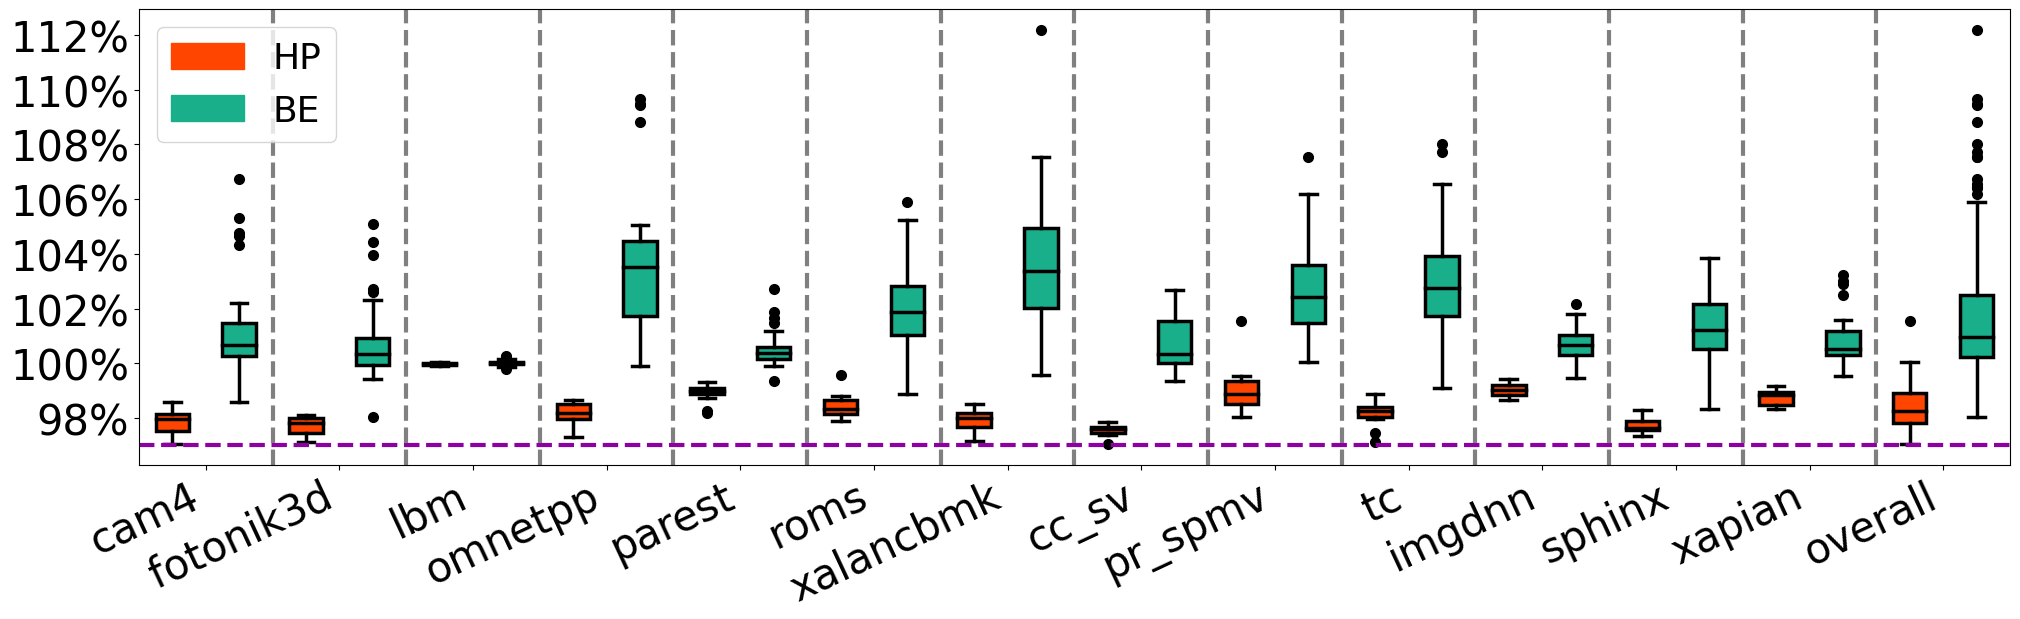

In [2]:


# sheet32 = all_sheets['64bucket']
sheet32 = all_sheets[select_bucket]


gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]

print("show max BE speed up")
for e in exps:
    max_row = sheet32[sheet32[e]==sheet32[e].max()]
    display(max_row[['workload0','workload1','workload2','workload3']+exps])

print('show max BE sum speedup')
sum_col = sheet32[exps].sum(axis=1)
max_idx = sum_col.idxmax()
max_row = sheet32.loc[max_idx]
display(max_row[['workload0','workload1','workload2','workload3']+exps])

data = []

overall_datas = [ [] for _ in range(napps) ]

for w0 in w0s:
    bar0 = gsheet32.get_group(w0)[exps[0]].values
    data.append(bar0)
    overall_datas[0].extend(bar0)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data.append(be_datas)
    overall_datas[1].extend(be_datas)

data.extend(overall_datas)

print(sorted(overall_datas[1],reverse=True)[:10])

# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(data, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

box_step = 2


# set box colors alternatively
colors = contrasting_orange
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0xlabels)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
ax.set_xticklabels(w0xlabels)

plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# set legend
legends = [Patch(color=contrasting_orange[i],label=f'{app_labels[i]}')
                    for i in range(2)]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout(pad=0)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_overall_97.png', dpi=300)

[0.8147561755623282, 0.8332842019124204, 0.836321404948224, 0.8424438023283503, 0.8456461110386925, 0.8554526132608725, 0.856301498067114, 0.8574633736756044, 0.8581392642296163, 0.8664729447405297]


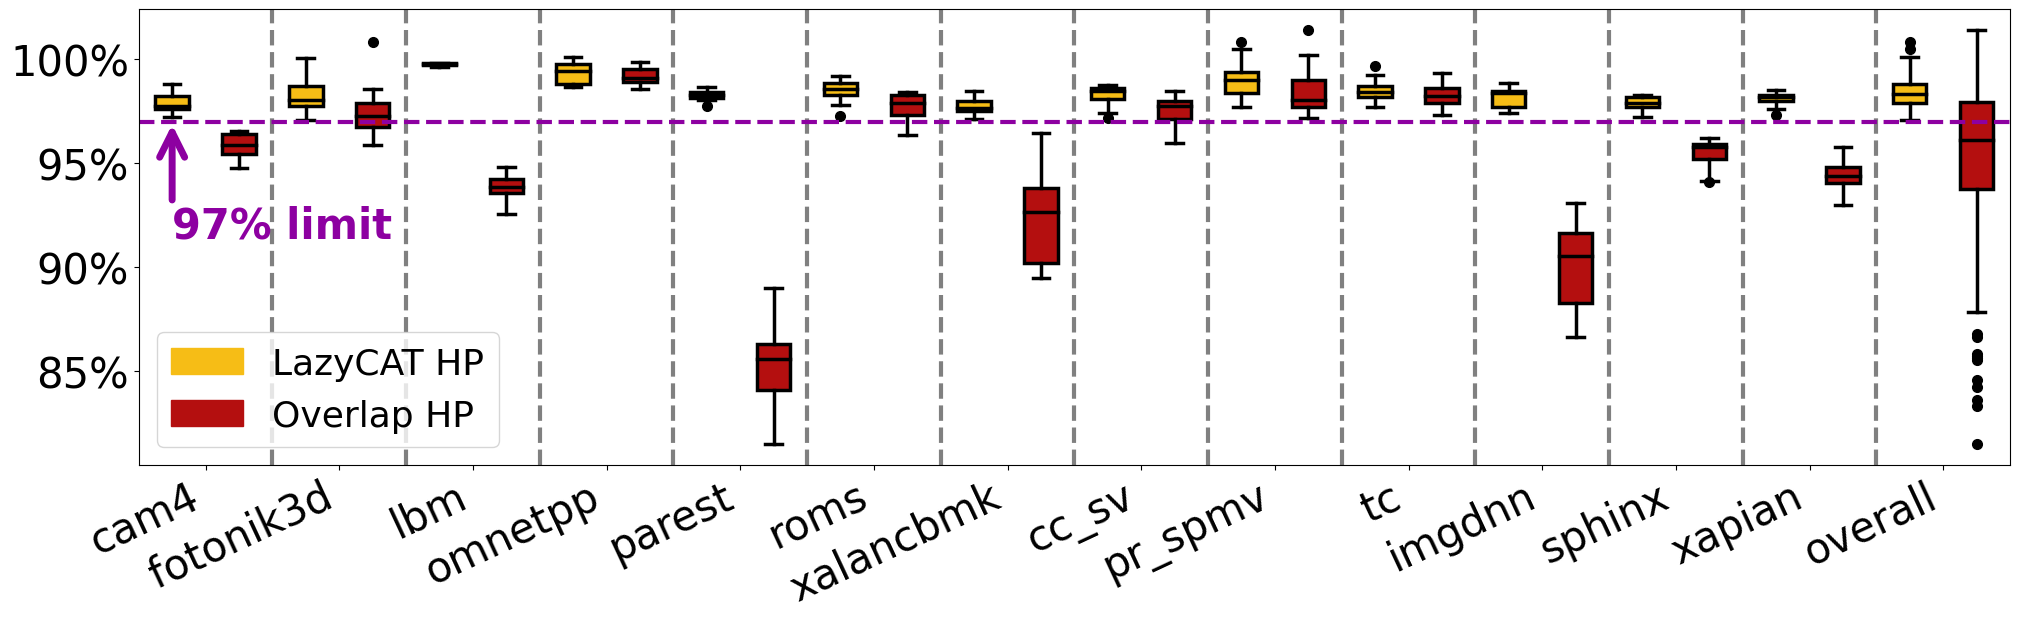

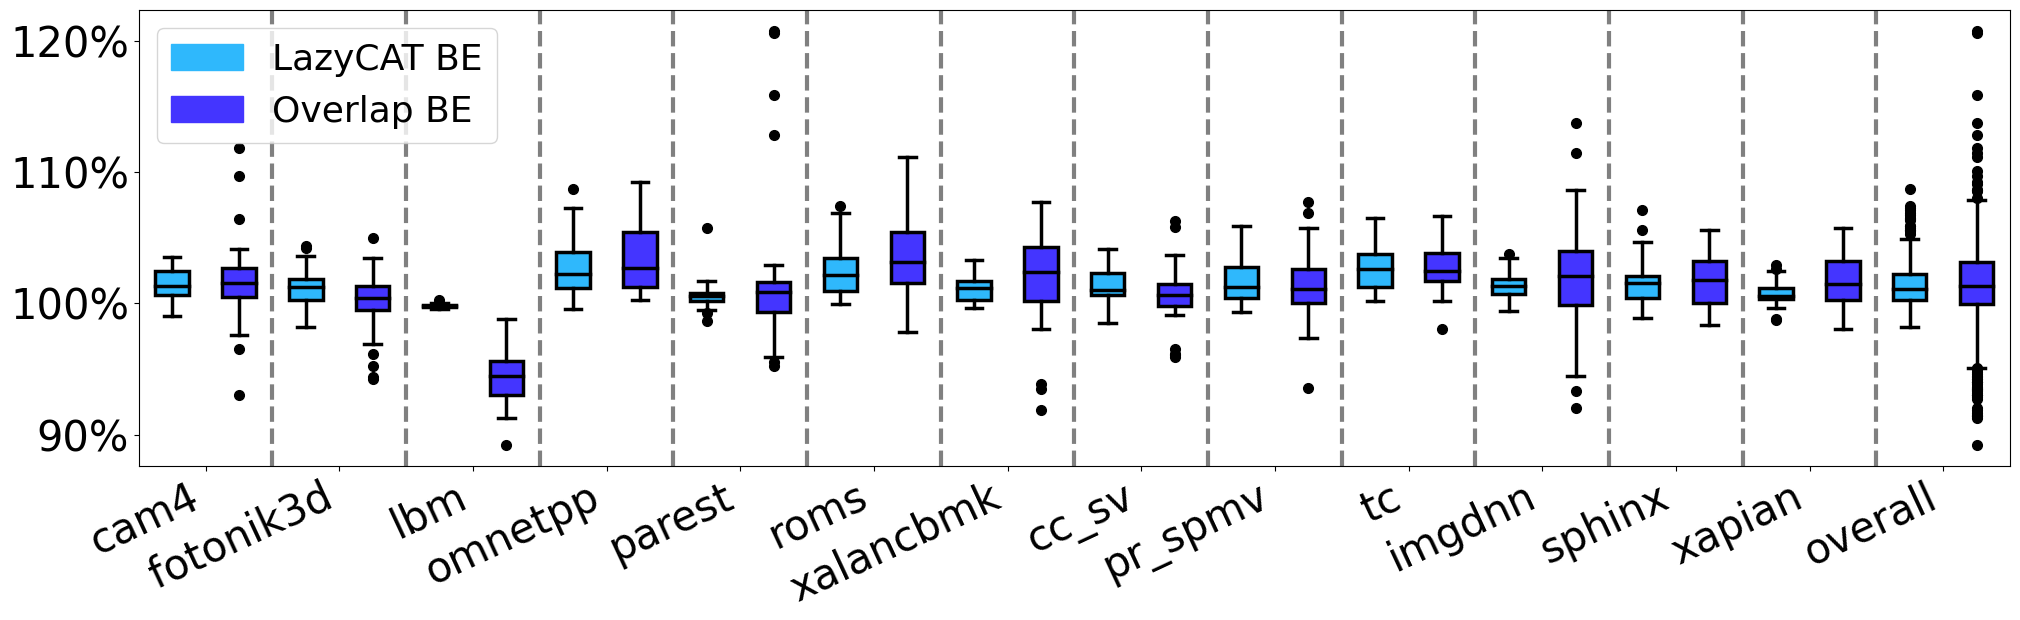

In [12]:

# w0s = ["astar_biglakes", "xalancbmk","omnetpp","gcc_200","soplex_pds","gcc_cpdecl","sphinx3",
#  "cactusADM", "gcc_g23", "mcf", "gcc_scilab", "lbm",]


sheet32 = all_sheets[select_bucket]

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
overl_f = 'OverlapOne_speedup{}'

data_apps = [list() for _ in range(napps)]
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]

overall_datas = [ [ [],[] ] for _ in range(napps) ]

for w0 in w0s:
    bar0 = gsheet32.get_group(w0)[lazy_exps[0]].values
    data_apps[0].append(bar0)
    overall_datas[0][0].extend(bar0)

    bar0 = gsheet32.get_group(w0)[overl_exps[0]].values
    data_apps[0].append(bar0)
    overall_datas[0][1].extend(bar0)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[lazy_exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data_apps[1].append(be_datas)
    overall_datas[1][0].extend(be_datas)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[overl_exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data_apps[1].append(be_datas)
    overall_datas[1][1].extend(be_datas)

data_apps[0].extend(overall_datas[0])
data_apps[1].extend(overall_datas[1])

print(sorted(overall_datas[0][1])[:10])

for appi in range(len(app_labels)):
    box_step = 2
    # draw boxplots
    fig, ax = plt.subplots()
    bp = ax.boxplot(data_apps[appi], showfliers=True, patch_artist=True,
                    capprops=dict(color='black', linewidth=2.5),
                    whiskerprops=dict(color='black', linewidth=2.5),
                    boxprops=dict(color='black', linewidth=2.5),
                    meanprops=dict(color='black', linewidth=2.5),
                    medianprops=dict(color='black', linewidth=2.5),
                    flierprops=dict(
                        marker='o',
                        markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

    # set box colors alternatively
    colors = contrasting_orange[3+2*appi:]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % box_step])

    # set vlines to separate different workloads
    for i in range(1, len(w0xlabels)):
        ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')
    
    if appi == 0:
        ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')
        ax.annotate( '', xy=(1, 0.97), xytext=(1, 0.931),
              arrowprops=dict(arrowstyle="->", linewidth=5 ,facecolor='#8D00A1',ec='#8D00A1') )
        ax.annotate( '97% limit', xy=(1, 0.93),color='#8D00A1',fontsize = 30,
                    xytext=(1, 0.93) , va = "top", ha="left" ,fontweight='bold')
        # ax.annotate('97% target', (1, 0.97), color='#8D00A1',
        #     xytext=(3, 0.92),
        #     arrowprops=dict(facecolor='#8D00A1',ec='#8D00A1', shrink=0.2),
        #     fontsize=18,fontweight='bold',
        #     horizontalalignment='center', verticalalignment='top')
        # ax.annotate('97% target', xy=(1, 0.97), xytext=(1.1, 0.97),)
        # ax.arrow(1, 0.93, 0, 0.04,length_includes_head=True,shape="right", width=0.2, fc='#8D00A1', ec='#8D00A1')

    # set xlabels
    xlabel0_val = np.average(np.arange(1, box_step+1))
    ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
    ax.set_xticklabels(w0xlabels)

    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
            # rotation_mode="anchor")
            rotation_mode="default")

    # ax.set_yticks(MultipleLocator)
    # ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

    # set legend
    legends = [Patch(color=colors[0],label=f'LazyCAT {app_labels[appi]}'),
                    Patch(color=colors[1],label=f'Overlap {app_labels[appi]}')]
    plt.legend(handles = legends)
    # plt.legend(handles = legends,loc='upper right')
    # plt.title(exps[0])
    fig.set_size_inches(fig_inchs)
    fig.tight_layout(pad=0)
    # plt.show()
    plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_compare_overlap_{app_labels[appi]}.png', dpi=300)

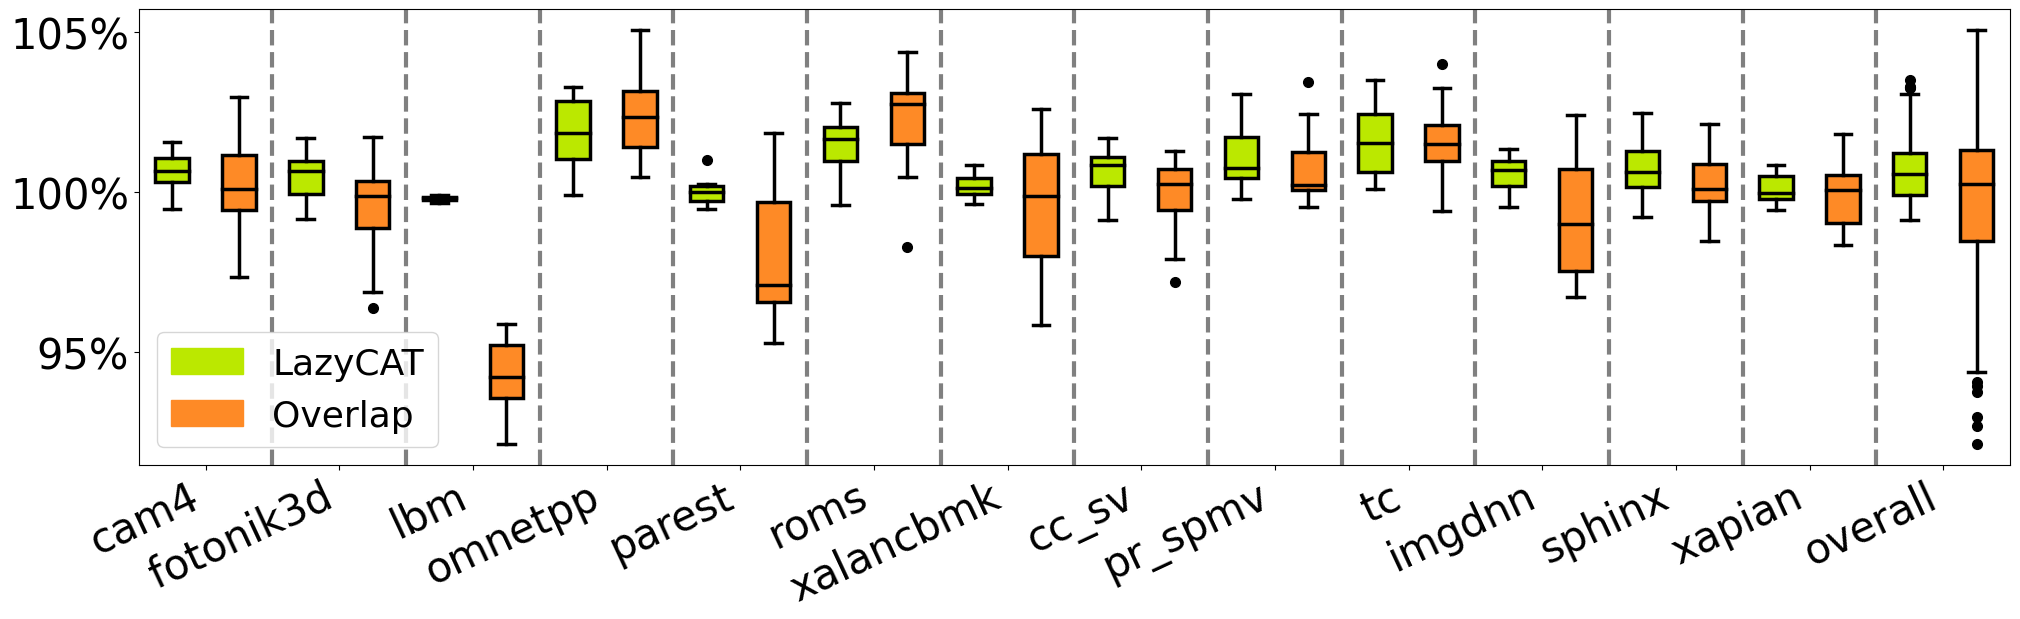

In [82]:


sheet32 = all_sheets[select_bucket]

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
overl_f = 'OverlapOne_speedup{}'

# data_apps = [list() for _ in range(napps)]
throughput_all = []
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]

overall_datas = [[], []]

policy_use_exps = [lazy_exps, overl_exps]

for w0 in w0s:
    for i,select_exps in enumerate(policy_use_exps):
        hpbe_datas = []
        for c in range(0, ncore):
            hpbe_datas.append(gsheet32.get_group(w0)[select_exps[c]].values)
        # average the throughput of all HP and BE combinations
        hpbe_datas = np.average(hpbe_datas, axis=0)
        throughput_all.append(hpbe_datas)
        overall_datas[i].extend(hpbe_datas)

throughput_all.extend(overall_datas)

box_step = 2
# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(throughput_all, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

# set box colors alternatively
colors = contrasting_orange[8:]
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0xlabels)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
ax.set_xticklabels(w0xlabels)

plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# set legend
legends = [Patch(color=colors[0],label=f'LazyCAT'),
                Patch(color=colors[1],label=f'Overlap')]
plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout(pad=0)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_compare_overlap_WeightedSpeedup.png', dpi=300)

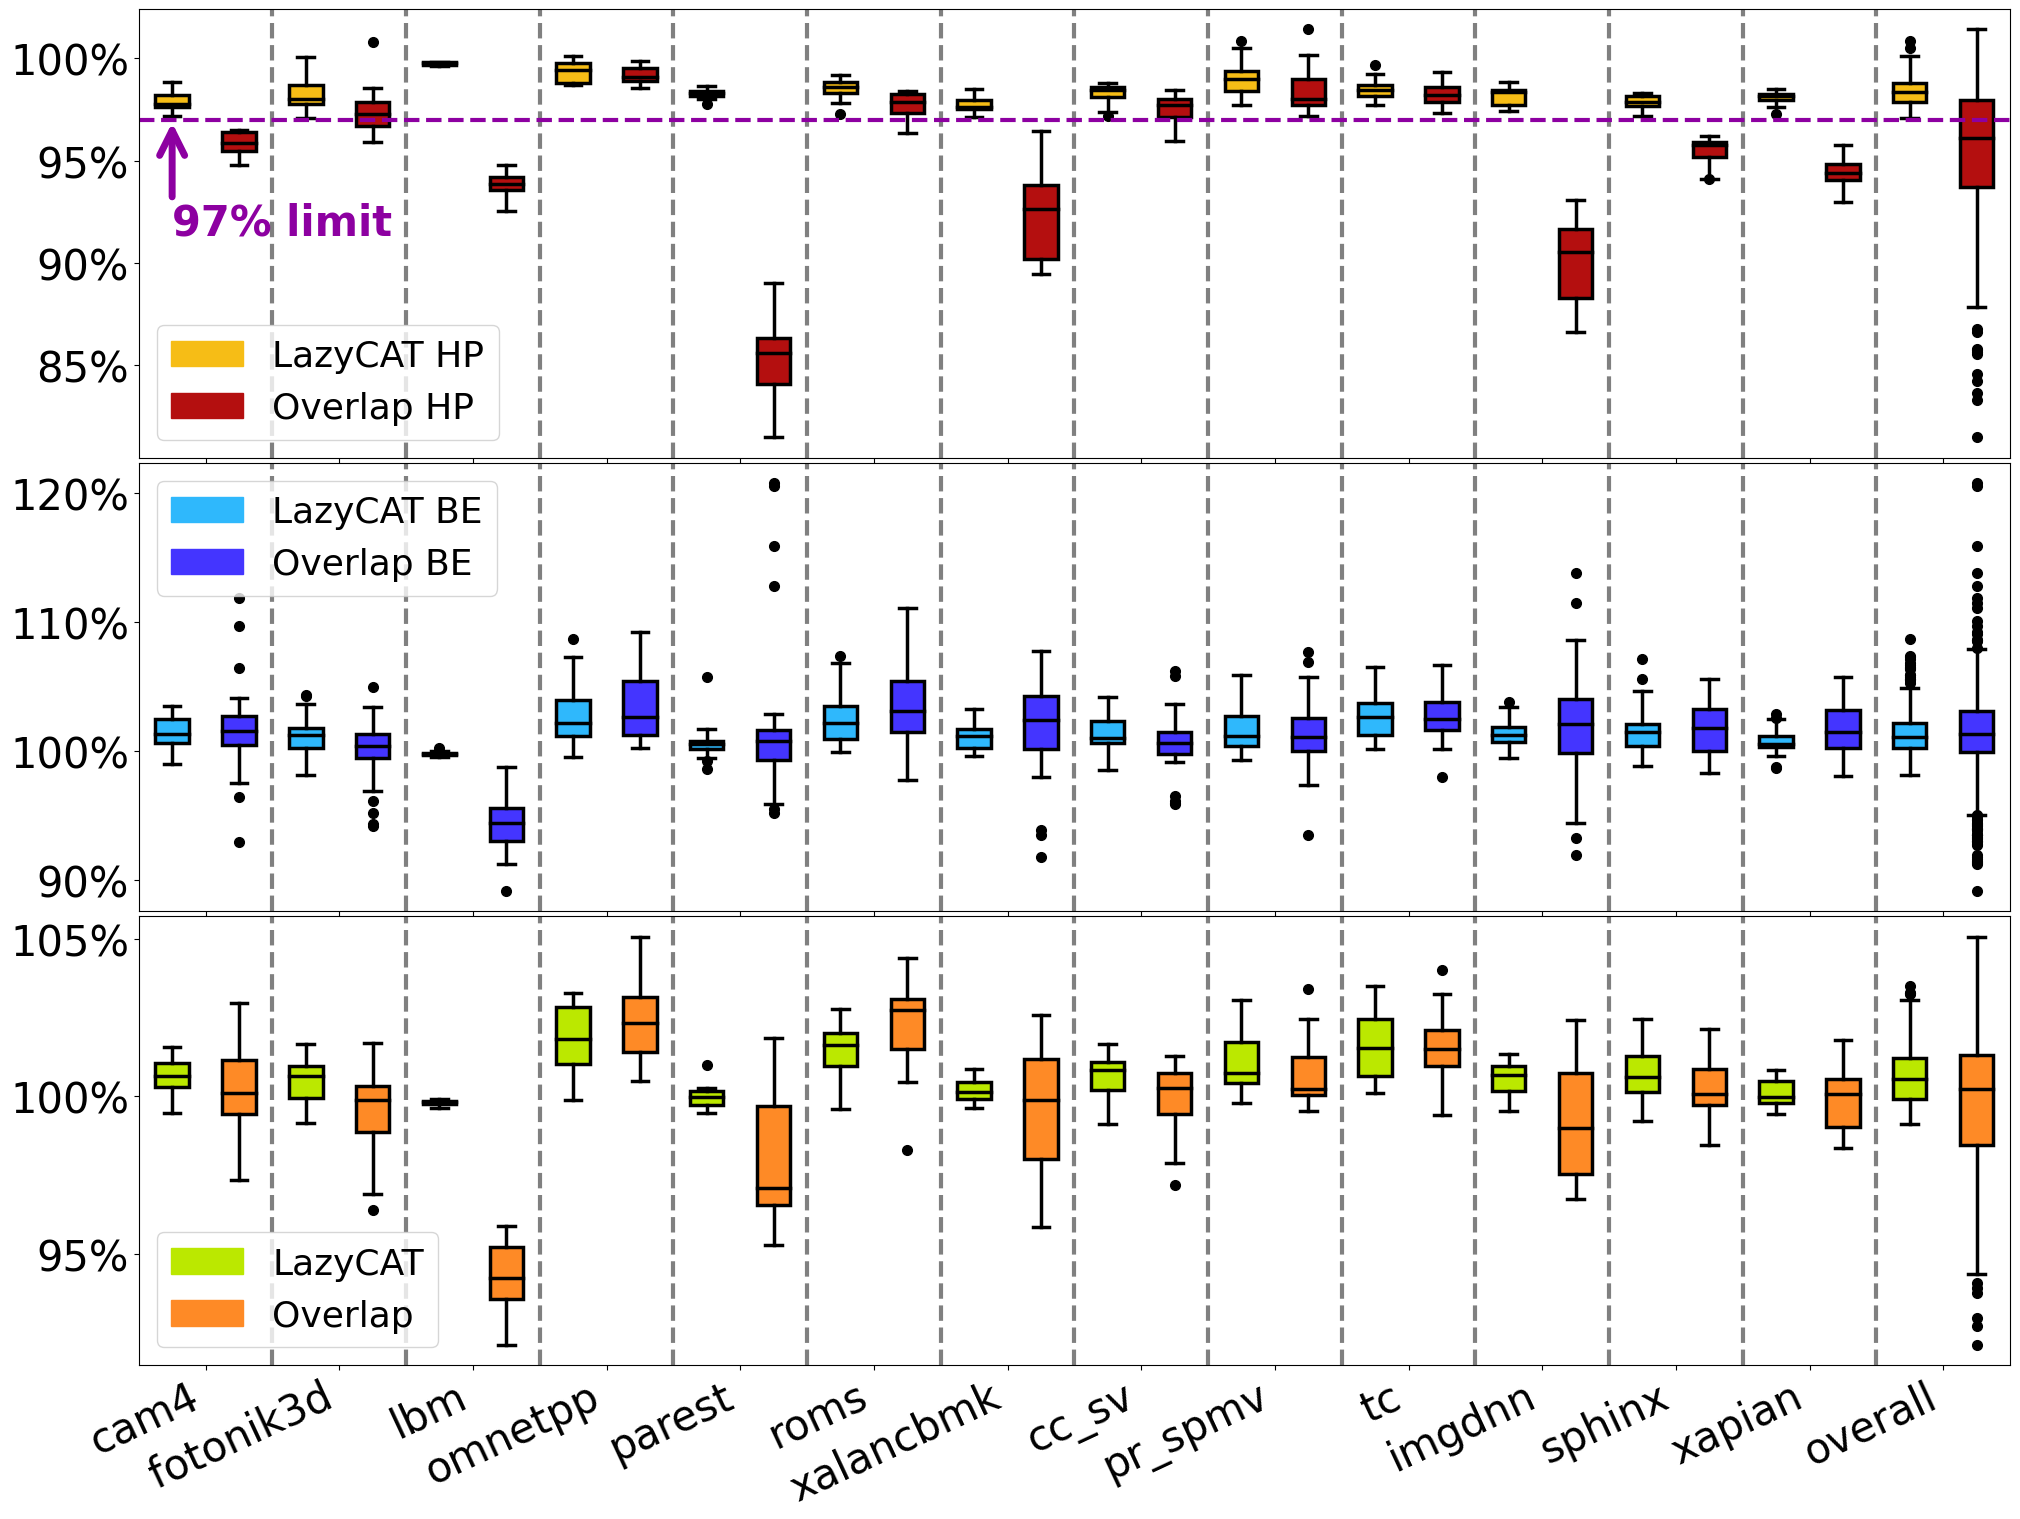

In [83]:
three_fig_size = (fig_inchs[0], fig_inchs[1]*2.5)
fig, axs = plt.subplots(3, 1, figsize=three_fig_size, sharex=True)


sheet32 = all_sheets[select_bucket]

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
overl_f = 'OverlapOne_speedup{}'

data_apps = [list() for _ in range(napps)]
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]

overall_datas = [ [ [],[] ] for _ in range(napps) ]

for w0 in w0s:
    bar0 = gsheet32.get_group(w0)[lazy_exps[0]].values
    data_apps[0].append(bar0)
    overall_datas[0][0].extend(bar0)

    bar0 = gsheet32.get_group(w0)[overl_exps[0]].values
    data_apps[0].append(bar0)
    overall_datas[0][1].extend(bar0)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[lazy_exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data_apps[1].append(be_datas)
    overall_datas[1][0].extend(be_datas)

    be_datas = []
    for c in range(1, ncore):
        be_datas.append(gsheet32.get_group(w0)[overl_exps[c]].values)
    # concatenate all other BEs
    be_datas = np.concatenate(be_datas)
    # average the BE combination
    # be_datas = np.average(be_datas, axis=0)
    data_apps[1].append(be_datas)
    overall_datas[1][1].extend(be_datas)

data_apps[0].extend(overall_datas[0])
data_apps[1].extend(overall_datas[1])

for appi in range(len(app_labels)):
    box_step = 2
    # draw boxplots
    ax = axs[appi]
    bp = ax.boxplot(data_apps[appi], showfliers=True, patch_artist=True,
                    capprops=dict(color='black', linewidth=2.5),
                    whiskerprops=dict(color='black', linewidth=2.5),
                    boxprops=dict(color='black', linewidth=2.5),
                    meanprops=dict(color='black', linewidth=2.5),
                    medianprops=dict(color='black', linewidth=2.5),
                    flierprops=dict(
                        marker='o',
                        markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

    # set box colors alternatively
    colors = contrasting_orange[3+2*appi:]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % box_step])

    # set vlines to separate different workloads
    for i in range(1, len(w0xlabels)):
        ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')
    
    if appi == 0:
        ax.axhline(y=0.97, color='#8D00A1',linewidth=3, linestyle='--')
        ax.annotate( '', xy=(1, 0.97), xytext=(1, 0.931),
              arrowprops=dict(arrowstyle="->", linewidth=5 ,facecolor='#8D00A1',ec='#8D00A1') )
        ax.annotate( '97% limit', xy=(1, 0.93),color='#8D00A1',fontsize = 30,
                    xytext=(1, 0.93) , va = "top", ha="left" ,fontweight='bold')
        # ax.annotate('97% target', (1, 0.97), color='#8D00A1',
        #     xytext=(3, 0.92),
        #     arrowprops=dict(facecolor='#8D00A1',ec='#8D00A1', shrink=0.2),
        #     fontsize=18,fontweight='bold',
        #     horizontalalignment='center', verticalalignment='top')
        # ax.annotate('97% target', xy=(1, 0.97), xytext=(1.1, 0.97),)
        # ax.arrow(1, 0.93, 0, 0.04,length_includes_head=True,shape="right", width=0.2, fc='#8D00A1', ec='#8D00A1')

    # set xlabels
    xlabel0_val = np.average(np.arange(1, box_step+1))
    ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
    ax.set_xticklabels(w0xlabels)

    plt.setp(ax.get_xticklabels(), rotation=25, ha="center",
            # rotation_mode="anchor")
            rotation_mode="default")

    # ax.set_yticks(MultipleLocator)
    # ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

    # set legend
    legends = [Patch(color=colors[0],label=f'LazyCAT {app_labels[appi]}'),
                    Patch(color=colors[1],label=f'Overlap {app_labels[appi]}')]
    ax.legend(handles = legends)
    # plt.legend(handles = legends,loc='upper right')
    # plt.title(exps[0])
    # fig.set_size_inches(fig_inchs)
    # fig.tight_layout(pad=0)
    # plt.show()


#draw throughput
#calculate throughput
throughput_all = []
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]
overall_datas = [[], []]
policy_use_exps = [lazy_exps, overl_exps]
for w0 in w0s:
    for i,select_exps in enumerate(policy_use_exps):
        hpbe_datas = []
        for c in range(0, ncore):
            hpbe_datas.append(gsheet32.get_group(w0)[select_exps[c]].values)
        # average the throughput of all HP and BE combinations
        hpbe_datas = np.average(hpbe_datas, axis=0)
        throughput_all.append(hpbe_datas)
        overall_datas[i].extend(hpbe_datas)

throughput_all.extend(overall_datas)
box_step = 2
# draw boxplots
ax = axs[2]
bp = ax.boxplot(throughput_all, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

# set box colors alternatively
colors = contrasting_orange[8:]
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0xlabels)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
ax.set_xticklabels(w0xlabels)

plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
# set legend
legends = [Patch(color=colors[0],label=f'LazyCAT'),
                Patch(color=colors[1],label=f'Overlap')]
ax.legend(handles = legends)

# plt.subplots_adjust(hspace=0.1)
plt.tight_layout(pad=0)
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_compare_overlap_3in1.png', dpi=300)

[1.0350900051043623, 1.0350900051043623, 1.0350900051043623, 1.0329418908257026, 1.0329418908257026, 1.0329418908257026, 1.0327780780224545, 1.0327780780224545, 1.0327780780224545, 1.0323942631054177]


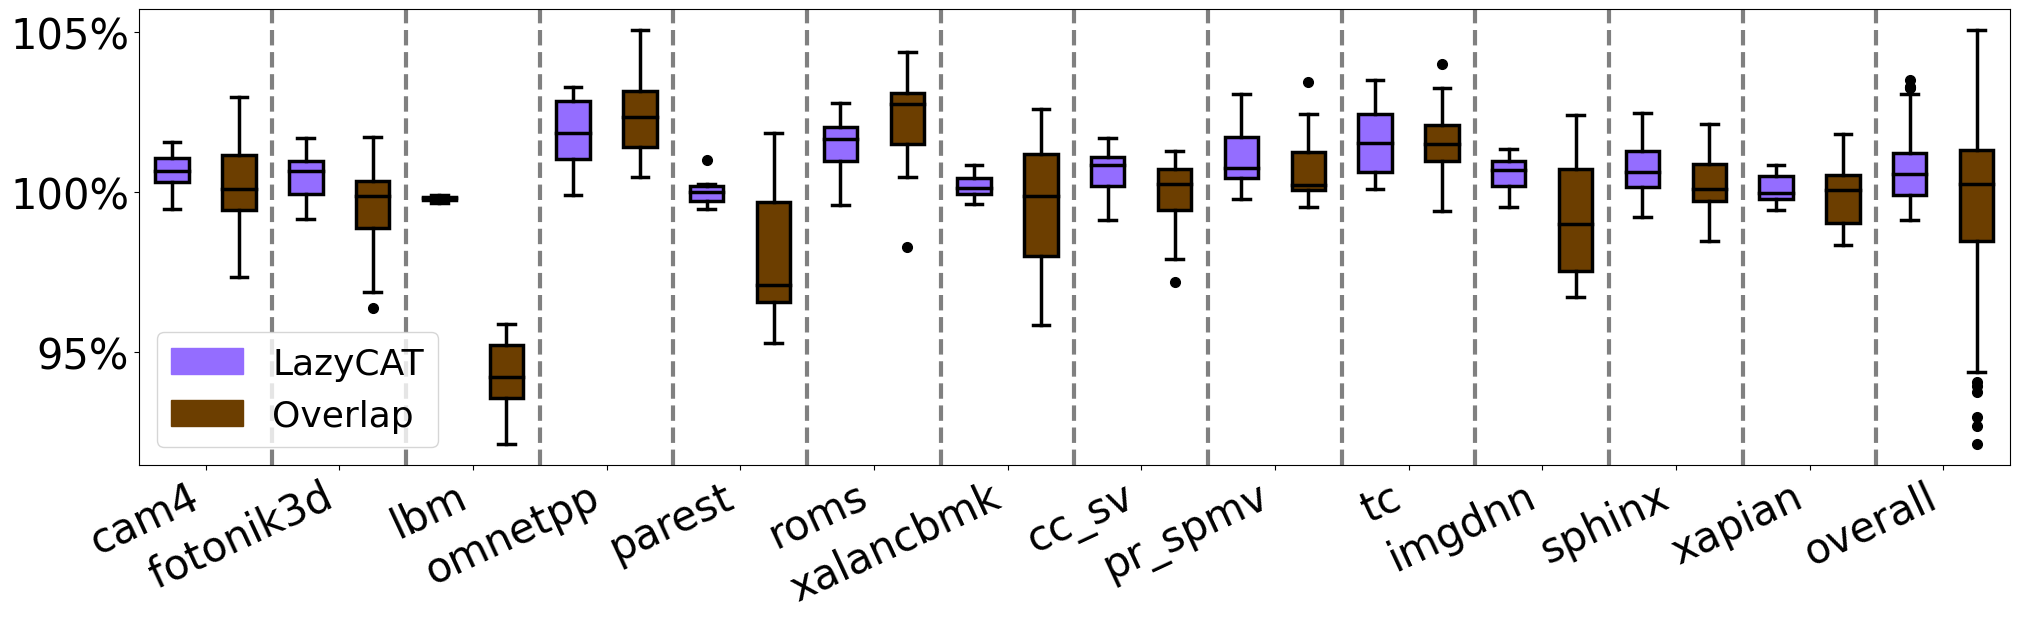

In [84]:
sheet32 = all_sheets[select_bucket]

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
overl_f = 'OverlapOne_speedup{}'

# data_apps = [list() for _ in range(napps)]
throughput_all = []
lazy_exps = [expf.format('0.97', corei) for corei in range(ncore)]
overl_exps = [overl_f.format(corei) for corei in range(ncore)]

overall_datas = [[], []]

policy_use_exps = [lazy_exps, overl_exps]

for w0 in w0s:
    for i,select_exps in enumerate(policy_use_exps):
        be_avg_datas = []
        for c in range(0, ncore):
            be_avg_datas.append(gsheet32.get_group(w0)[select_exps[c]].values)
        # average the throughput of all HP and BE combinations
        be_avg_datas = np.average(be_avg_datas, axis=0)
        throughput_all.append(be_avg_datas)
        overall_datas[i].extend(be_avg_datas)

throughput_all.extend(overall_datas)

print(sorted(throughput_all[-2] * (ncore-1),reverse=True)[:10])

box_step = 2
# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(throughput_all, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

# set box colors alternatively
colors = contrasting_orange[10:]
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0xlabels)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
ax.set_xticklabels(w0xlabels)

plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# set legend
legends = [Patch(color=colors[0],label=f'LazyCAT'),
                Patch(color=colors[1],label=f'Overlap')]
plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout(pad=0)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_compare_overlap_BEWeightedSpeedup.png', dpi=300)

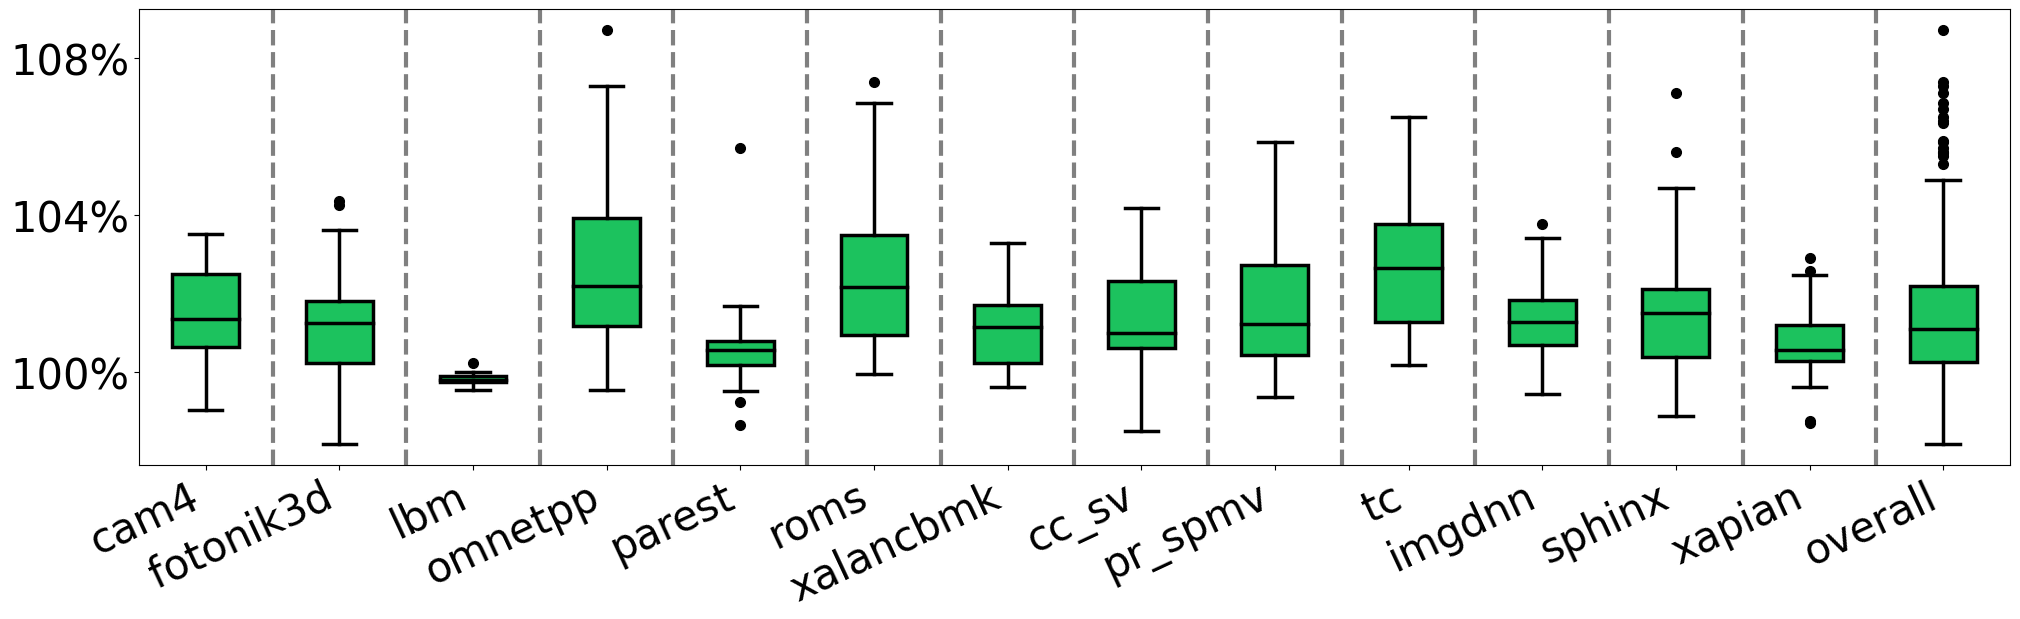

In [85]:

sheet32 = all_sheets[select_bucket]

gsheets = [sheet32.groupby(f'workload{c}') for c in range(1, ncore)]

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and cpu1
exps = [expf.format('0.97', c) for c in range(1, ncore)]

data = []


for w0 in w0s:
    tmp_be_datas = []
    for gs,e in zip(gsheets, exps):
        bar = gsheet32.get_group(w0)[e].values
        tmp_be_datas.append(bar)
    data.append(np.concatenate(tmp_be_datas))

overall_data = np.concatenate(data)
data.append(overall_data)

# draw boxplots
fig, ax = plt.subplots()
bp = ax.boxplot(data, showfliers=True, patch_artist=True,
                capprops=dict(color='black', linewidth=2.5),
                whiskerprops=dict(color='black', linewidth=2.5),
                boxprops=dict(color='black', linewidth=2.5),
                meanprops=dict(color='black', linewidth=2.5),
                medianprops=dict(color='black', linewidth=2.5),
                flierprops=dict(
                    marker='o',
                    markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

box_step = 1


# set box colors alternatively
colors = [
'#1CC25E',
'#946DFF',
'#6C3E00',
'#6193FF',
'#FF988E',
'#36BCCB',]
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors[i % box_step])

# set vlines to separate different workloads
for i in range(1, len(w0xlabels)):
    ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
ax.set_xticklabels(w0xlabels)


plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

# set legend
# legends = [Patch(color=colors[0],label=f'core1 speedup')]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs)
fig.tight_layout(pad=0)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_accepter_97.png', dpi=300)

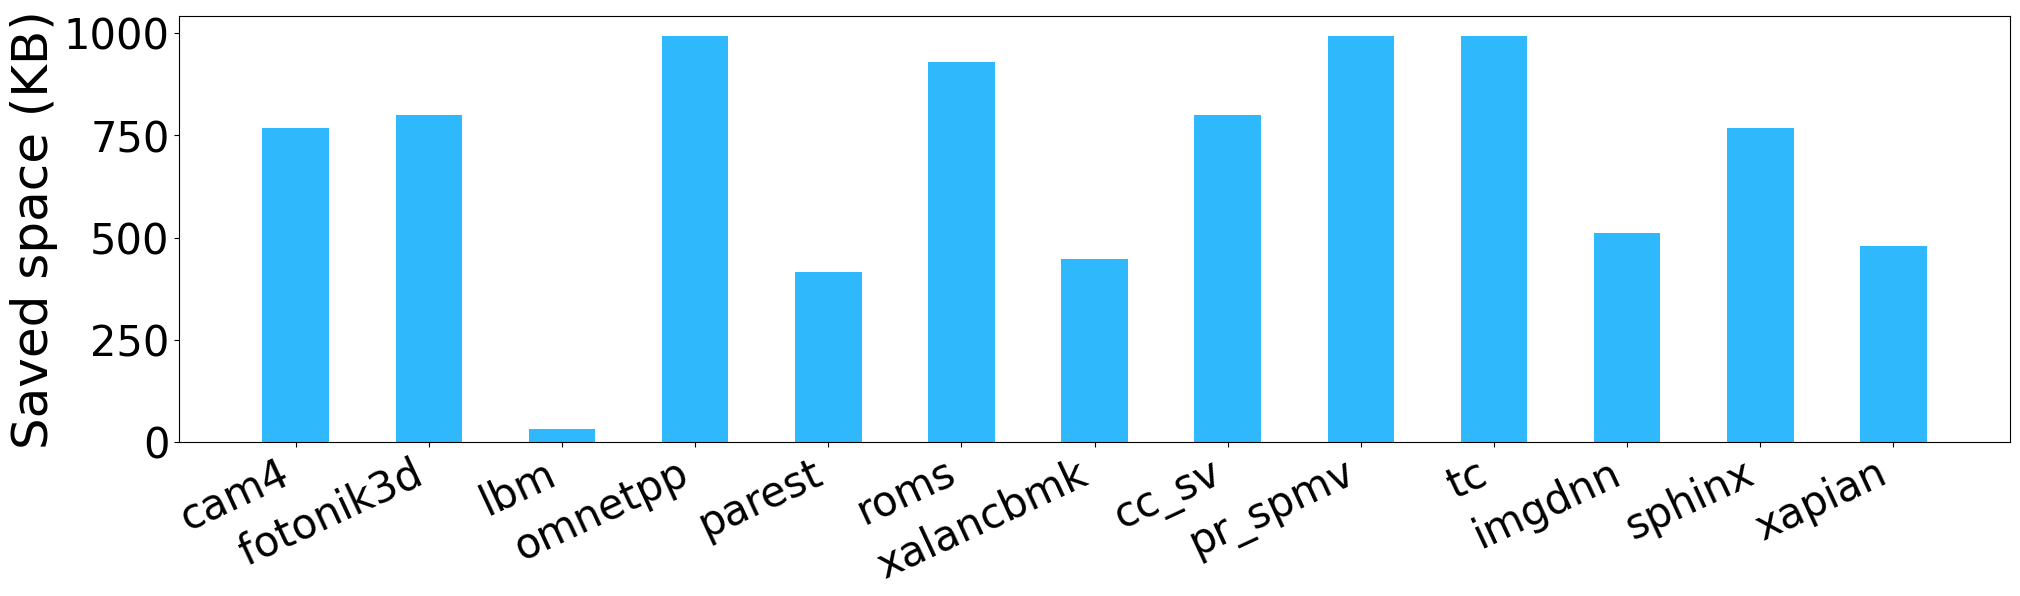

In [20]:
sheet32 = all_sheets['32_target_0.97_in64']

data = []

all_set = use_conf['all_set']

for w0 in w0s:
    target = sheet32[w0].values[0]
    save_space = (64 - target) * (all_set // 64) * 64 // 1024
    data.append(save_space)


# draw boxplots
fig, ax = plt.subplots()

colors = [
'#1CC25E',
'#946DFF',
'#6C3E00',
'#6193FF',
'#FF988E',
'#36BCCB',]

bcolor = '#2FB8FC'

b = ax.bar(np.arange(1,len(w0s)+1) ,data, color=bcolor, width=0.5)

box_step = 1
# set xlabels
xlabel0_val = np.average(np.arange(1, box_step+1))
ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0s))])
ax.set_xticklabels(w0s)


plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
        # rotation_mode="anchor")
        rotation_mode="default")

# ax.set_yticks(MultipleLocator)
# ax.set_ylim(0, 1)
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
ax.set_ylabel('Saved space (KB)')
# set legend
# legends = [Patch(color=bcolor,label=f'saved space (KB)')]
# legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
#             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
#             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
# plt.title(exps[0])
fig.set_size_inches(fig_inchs[0], fig_inchs[1]*0.95)
# fig.subplots_adjust(left=0.15, bottom=0.15)
# fig.tight_layout(pad=0.05,h_pad=1.2, w_pad=0.2)
fig.tight_layout(pad=0)
# fig.subplots_adjust(bottom=0.1)
# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_bar_savedspace_32bucket_97.png', dpi=300)
plt.show()

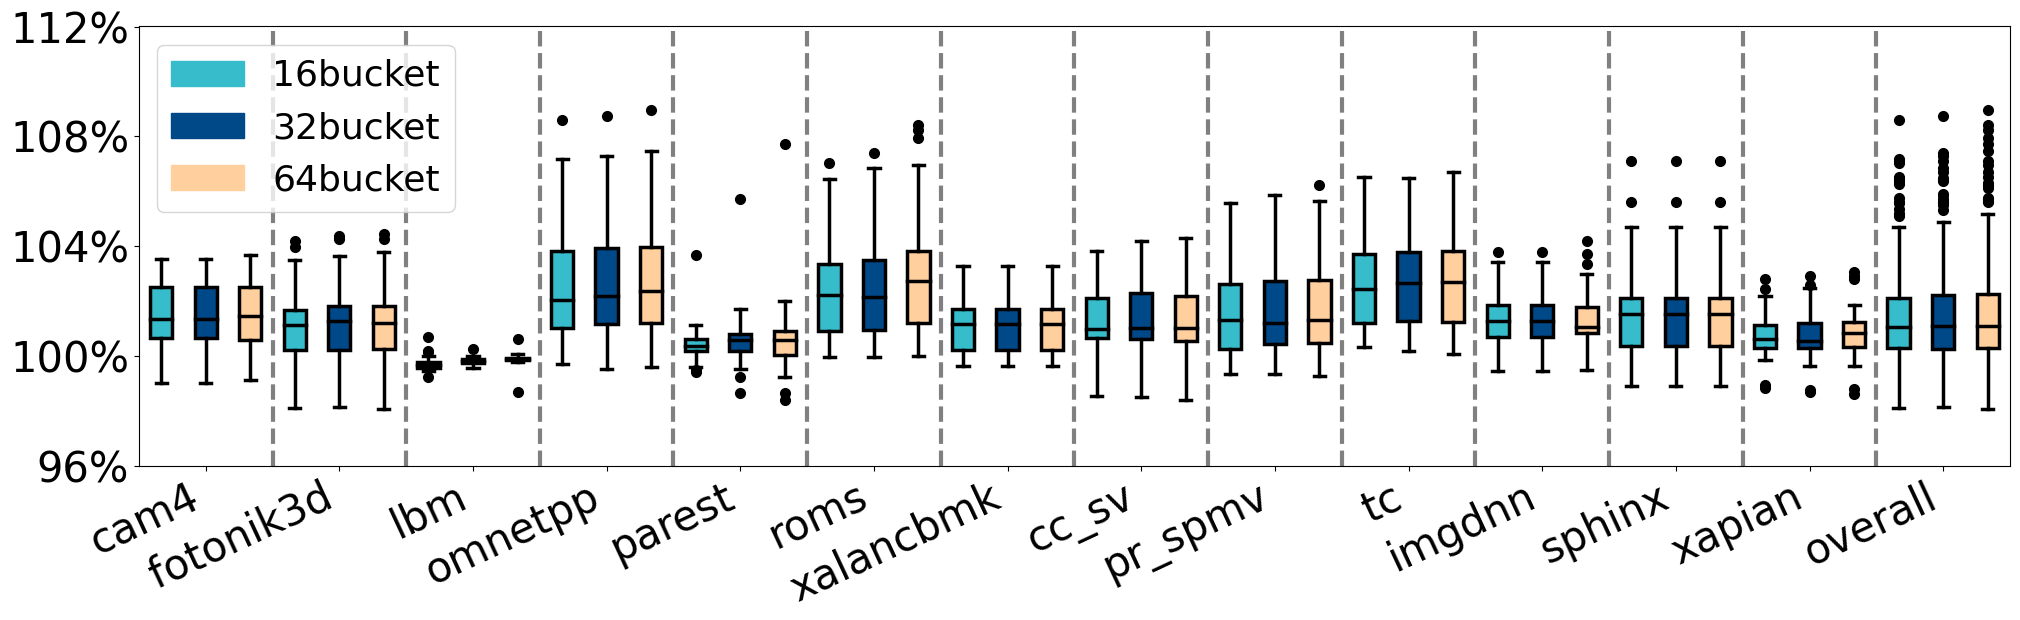

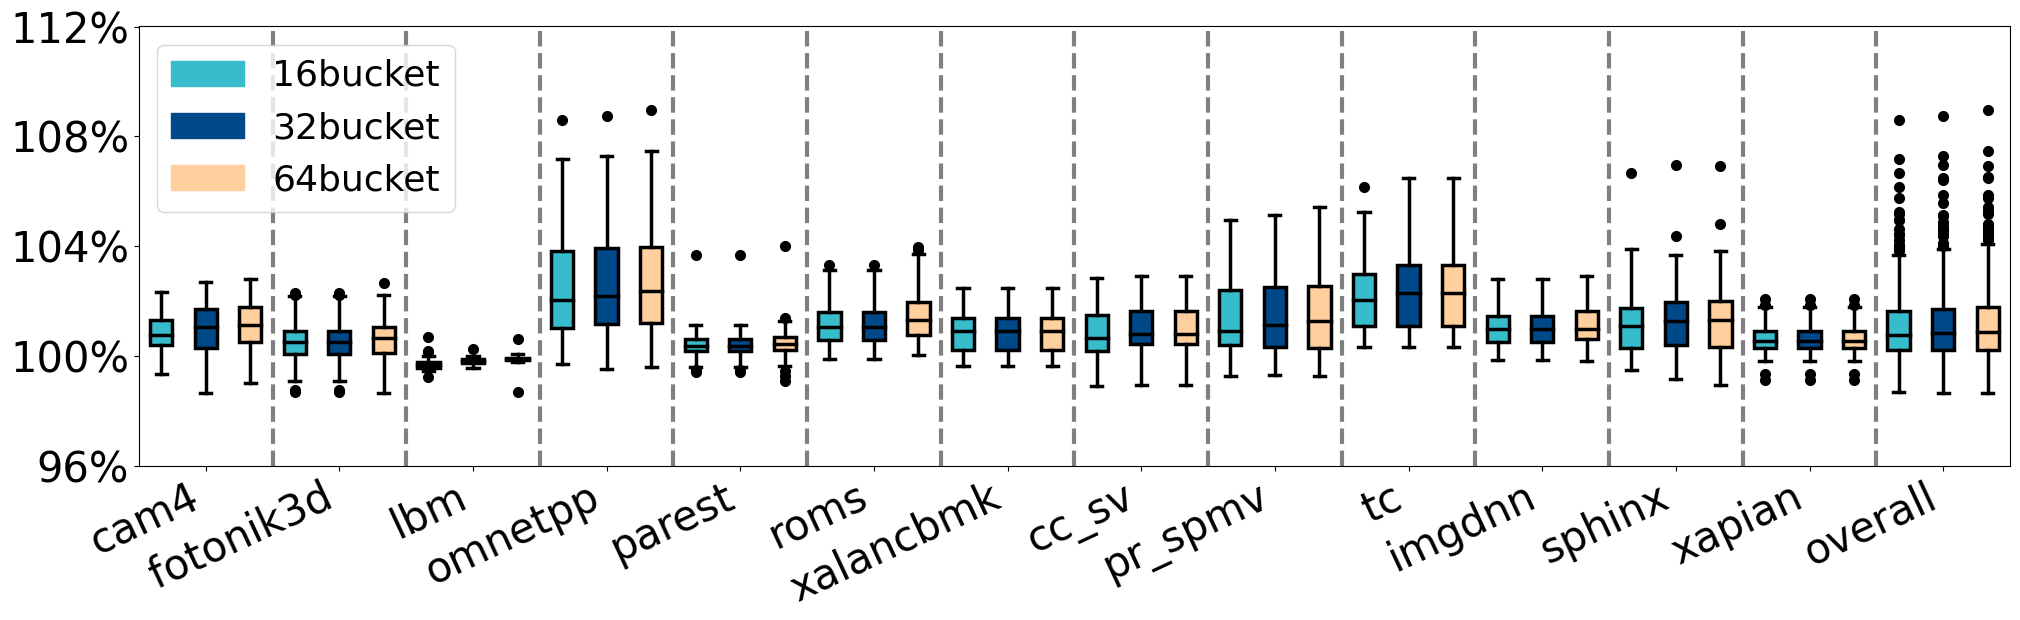

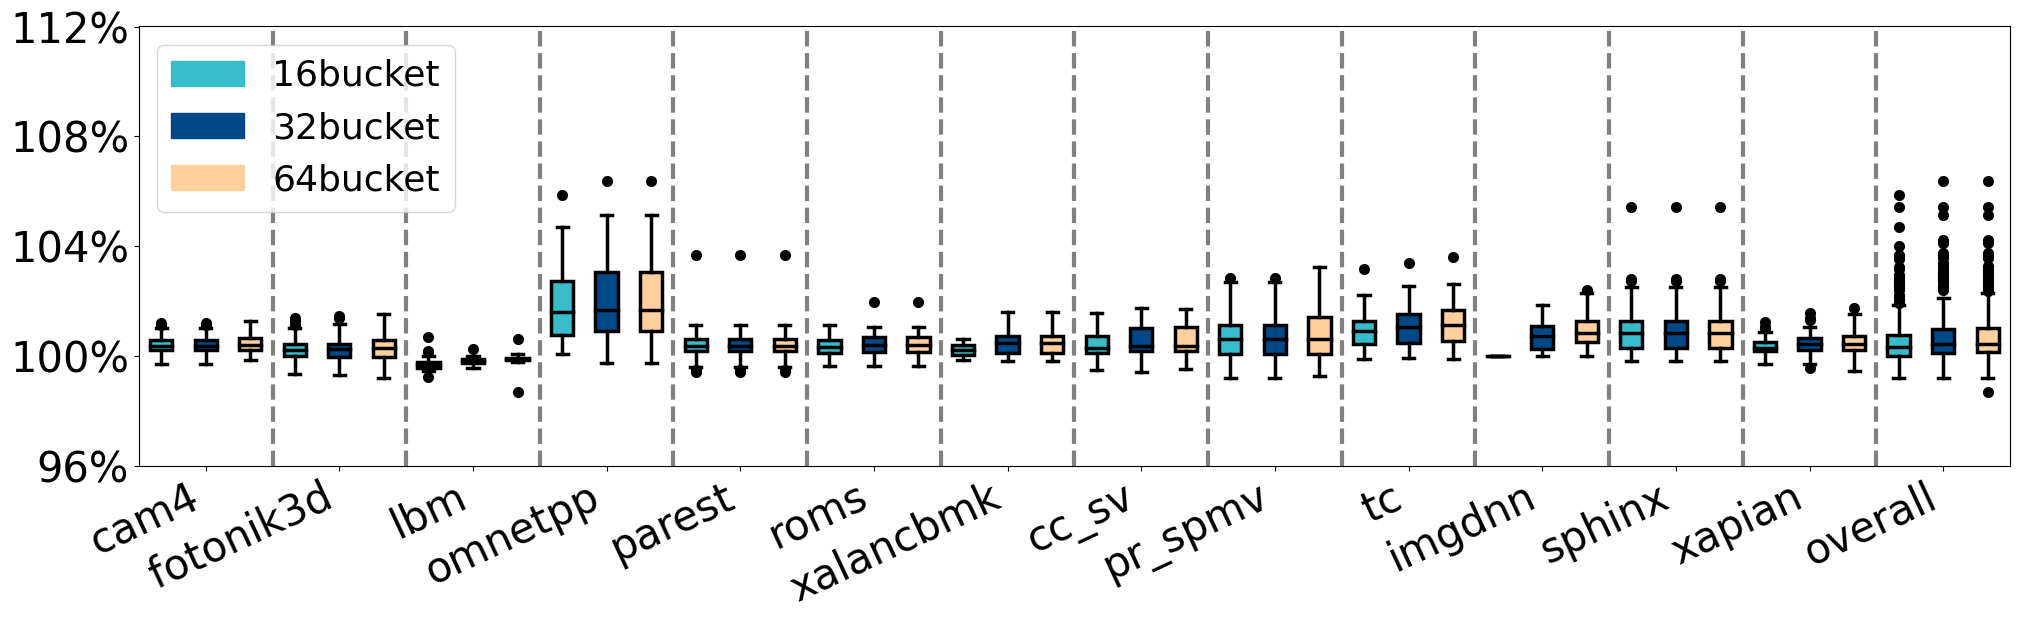

In [87]:
bucket_list = ['16bucket', '32bucket', '64bucket']
mb_sheets = [ all_sheets[bucket].groupby("workload0") for bucket in bucket_list ]

target = ['0.97','0.98','0.99']
for ts in target:
    exp = [f'realOneWithTarget{ts}_speedup{c}' for c in range(1,ncore)]
    data = []
    overall_datas = [ [] for _ in range(len(bucket_list)) ]
    for w0 in w0s:
        for grouped,odata in zip(mb_sheets, overall_datas):
            be_datas = []
            for e in exp:
                be_datas.append(grouped.get_group(w0)[e].values)
            data.append(np.concatenate(be_datas))
            odata.extend(np.concatenate(be_datas))
    
    data.extend(overall_datas)

    # draw boxplots
    fig, ax = plt.subplots()
    bp = ax.boxplot(data, showfliers=True, patch_artist=True,
            capprops=dict(color='black', linewidth=2.5),
            whiskerprops=dict(color='black', linewidth=2.5),
            boxprops=dict(color='black', linewidth=2.5),
            meanprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=2.5),
            flierprops=dict(
                marker='o',
                markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

    box_step = len(mb_sheets)

    # set box colors alternatively
    colors = ['#36BCCB',
    '#004988',
    '#FFCF9D',]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % box_step])

    # set vlines to separate different workloads
    for i in range(1, len(w0xlabels)):
        ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

    # set xlabels
    xlabel0_val = np.average(np.arange(1, box_step+1))
    ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
    ax.set_xticklabels(w0xlabels)

    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
            # rotation_mode="anchor")
            rotation_mode="default")

    # ax.set_yticks(MultipleLocator)
    ax.set_ylim(0.96, 1.12)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

    # set legend
    legends = [Patch(color=colors[i%box_step],label=f'{bucket_list[i]}')
                for i in range(0, box_step) ]
    # legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
    #             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
    #             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
    plt.legend(handles = legends,loc = 'upper left')
    # plt.title(exps[0])
    fig.set_size_inches(fig_inchs)
    fig.tight_layout(pad=0)
    # plt.show()
    plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_compare_buckets_{ts}.png', dpi=300)
    

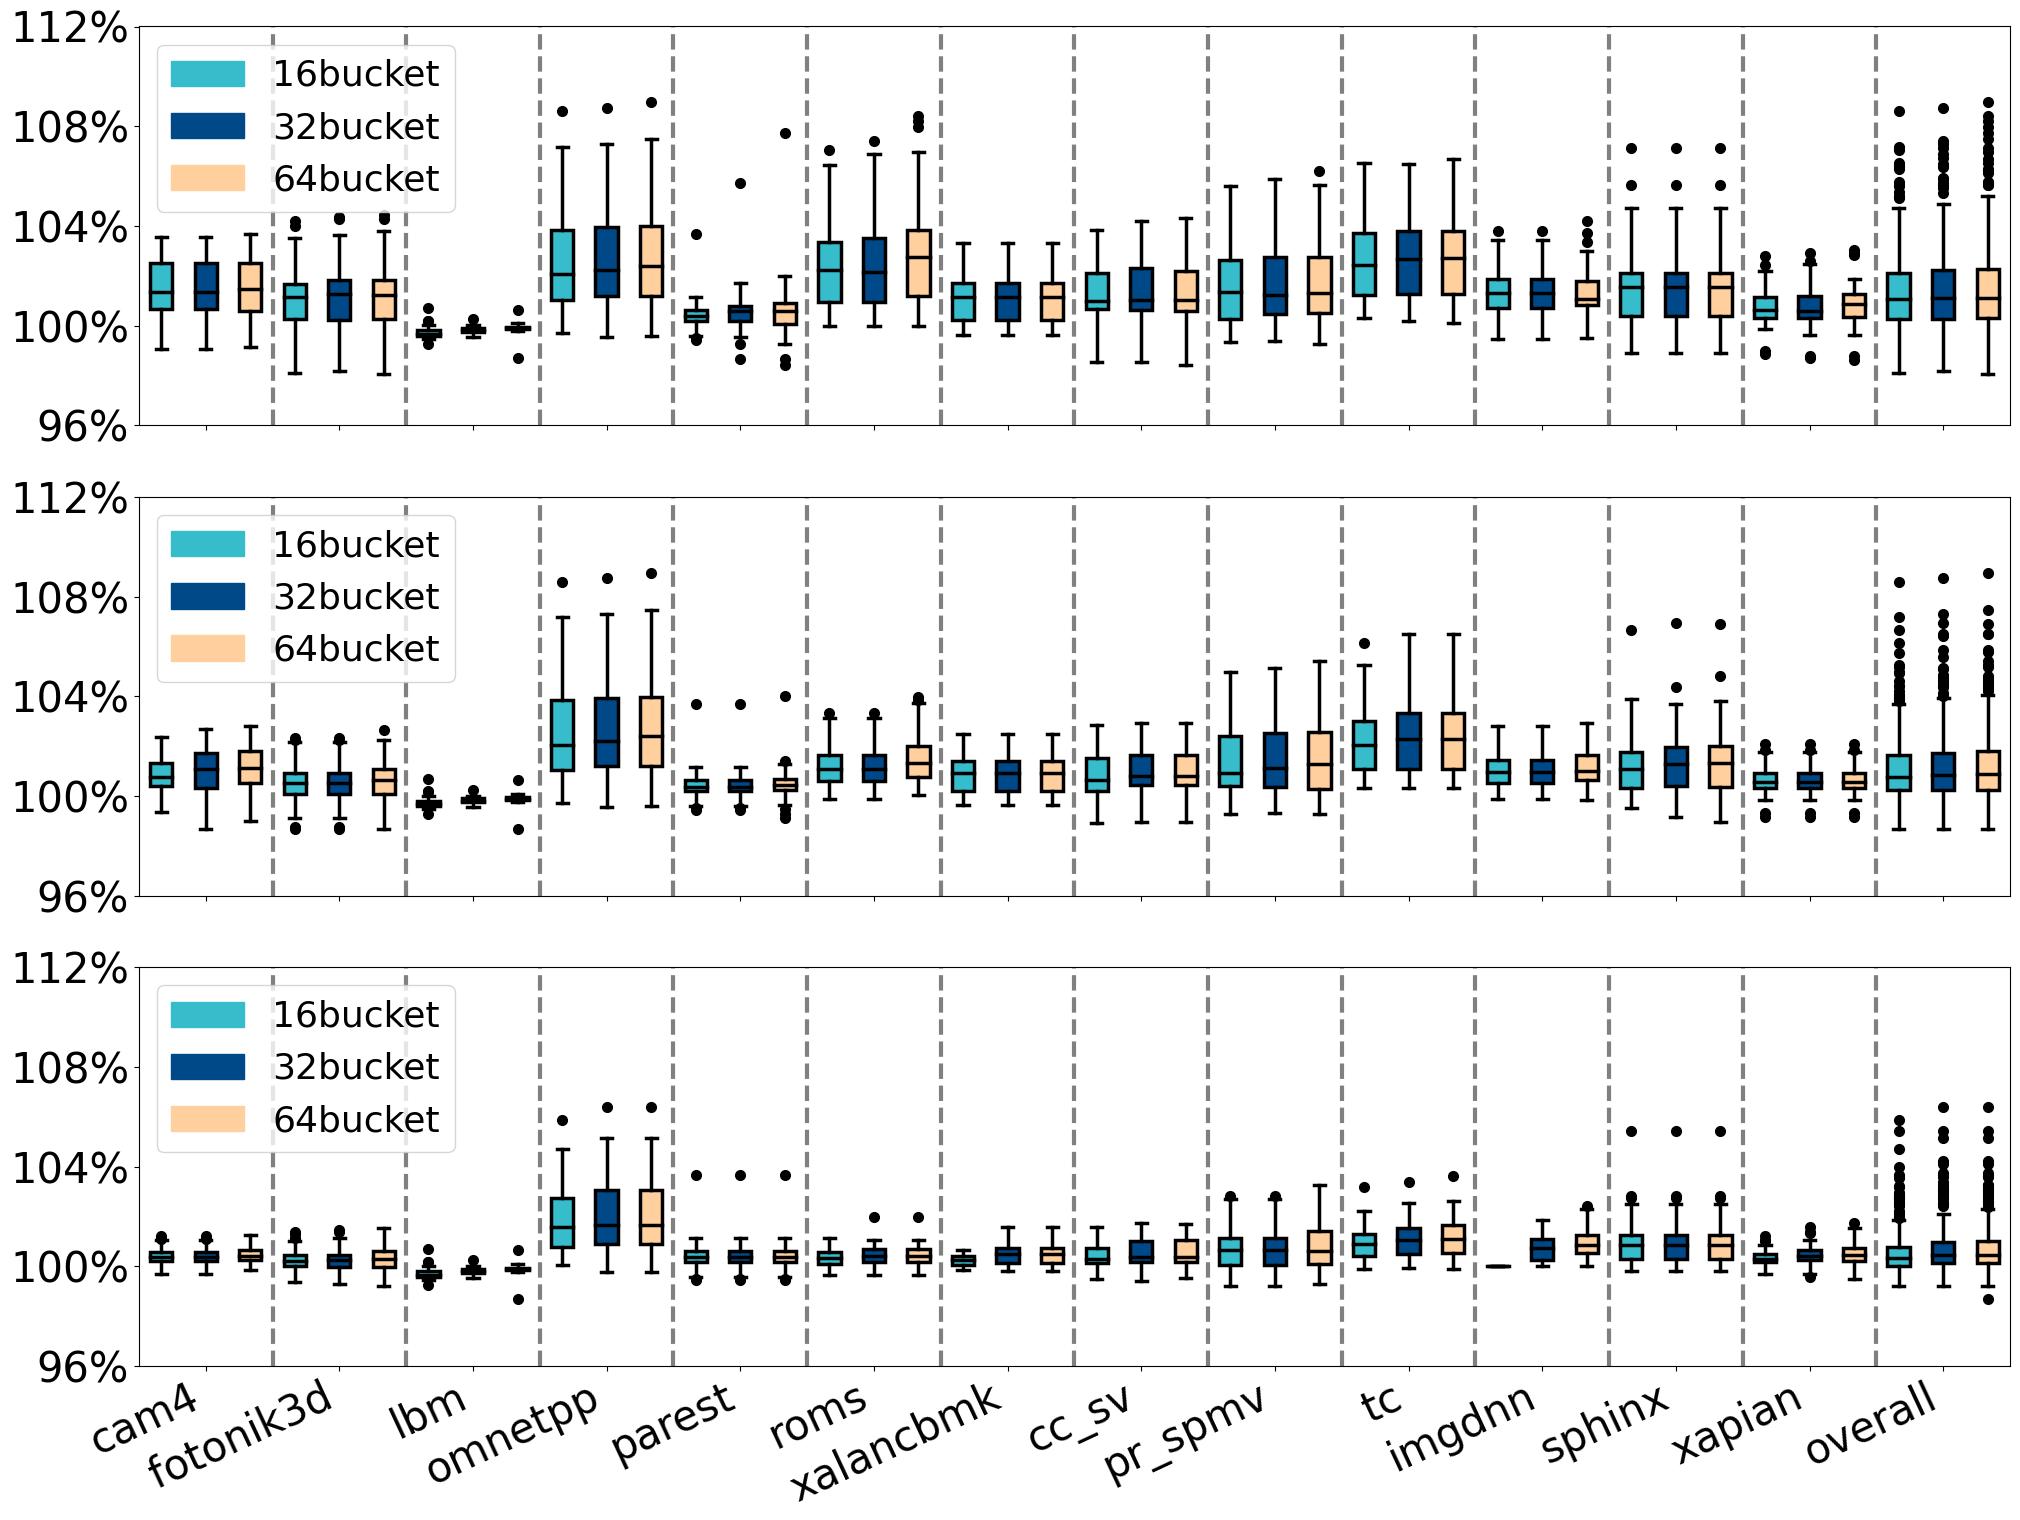

In [97]:

three_fig_size = (fig_inchs[0], fig_inchs[1]*2.5)
fig, axs = plt.subplots(3, 1, figsize=three_fig_size, sharex=True)

bucket_list = ['16bucket', '32bucket', '64bucket']
mb_sheets = [ all_sheets[bucket].groupby("workload0") for bucket in bucket_list ]

target = ['0.97','0.98','0.99']
for i,ts in enumerate(target):
    exp = [f'realOneWithTarget{ts}_speedup{c}' for c in range(1,ncore)]
    data = []
    overall_datas = [ [] for _ in range(len(bucket_list)) ]
    for w0 in w0s:
        for grouped,odata in zip(mb_sheets, overall_datas):
            be_datas = []
            for e in exp:
                be_datas.append(grouped.get_group(w0)[e].values)
            data.append(np.concatenate(be_datas))
            odata.extend(np.concatenate(be_datas))
    
    data.extend(overall_datas)

    # draw boxplots
    ax = axs[i]
    bp = ax.boxplot(data, showfliers=True, patch_artist=True,
            capprops=dict(color='black', linewidth=2.5),
            whiskerprops=dict(color='black', linewidth=2.5),
            boxprops=dict(color='black', linewidth=2.5),
            meanprops=dict(color='black', linewidth=2.5),
            medianprops=dict(color='black', linewidth=2.5),
            flierprops=dict(
                marker='o',
                markerfacecolor='black', linewidth=10, markersize=7, markeredgecolor='black'))

    box_step = len(mb_sheets)

    # set box colors alternatively
    colors = ['#36BCCB',
    '#004988',
    '#FFCF9D',]
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors[i % box_step])

    # set vlines to separate different workloads
    for i in range(1, len(w0xlabels)):
        ax.axvline(x=box_step*i+0.5, color='gray',linewidth=3, linestyle='--')

    # set xlabels
    xlabel0_val = np.average(np.arange(1, box_step+1))
    ax.set_xticks([box_step*x+xlabel0_val for x in range(0, len(w0xlabels))])
    ax.set_xticklabels(w0xlabels)

    plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
            # rotation_mode="anchor")
            rotation_mode="default")

    # ax.set_yticks(MultipleLocator)
    ax.set_ylim(0.96, 1.12)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.04))

    # set legend
    legends = [Patch(color=colors[i%box_step],label=f'{bucket_list[i]}')
                for i in range(0, box_step) ]
    # legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
    #             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
    #             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
    
    ax.legend(handles = legends,loc = 'upper left')
    # plt.legend(handles = legends,loc = 'upper left')
    # plt.title(exps[0])
    # fig.set_size_inches(fig_inchs)
    # fig.tight_layout(pad=0)
    # plt.show()
plt.tight_layout(pad=0)
plt.subplots_adjust(hspace=0.18)
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_boxplot_compare_3buckets.png', dpi=300)
    

(468,)
(468,)


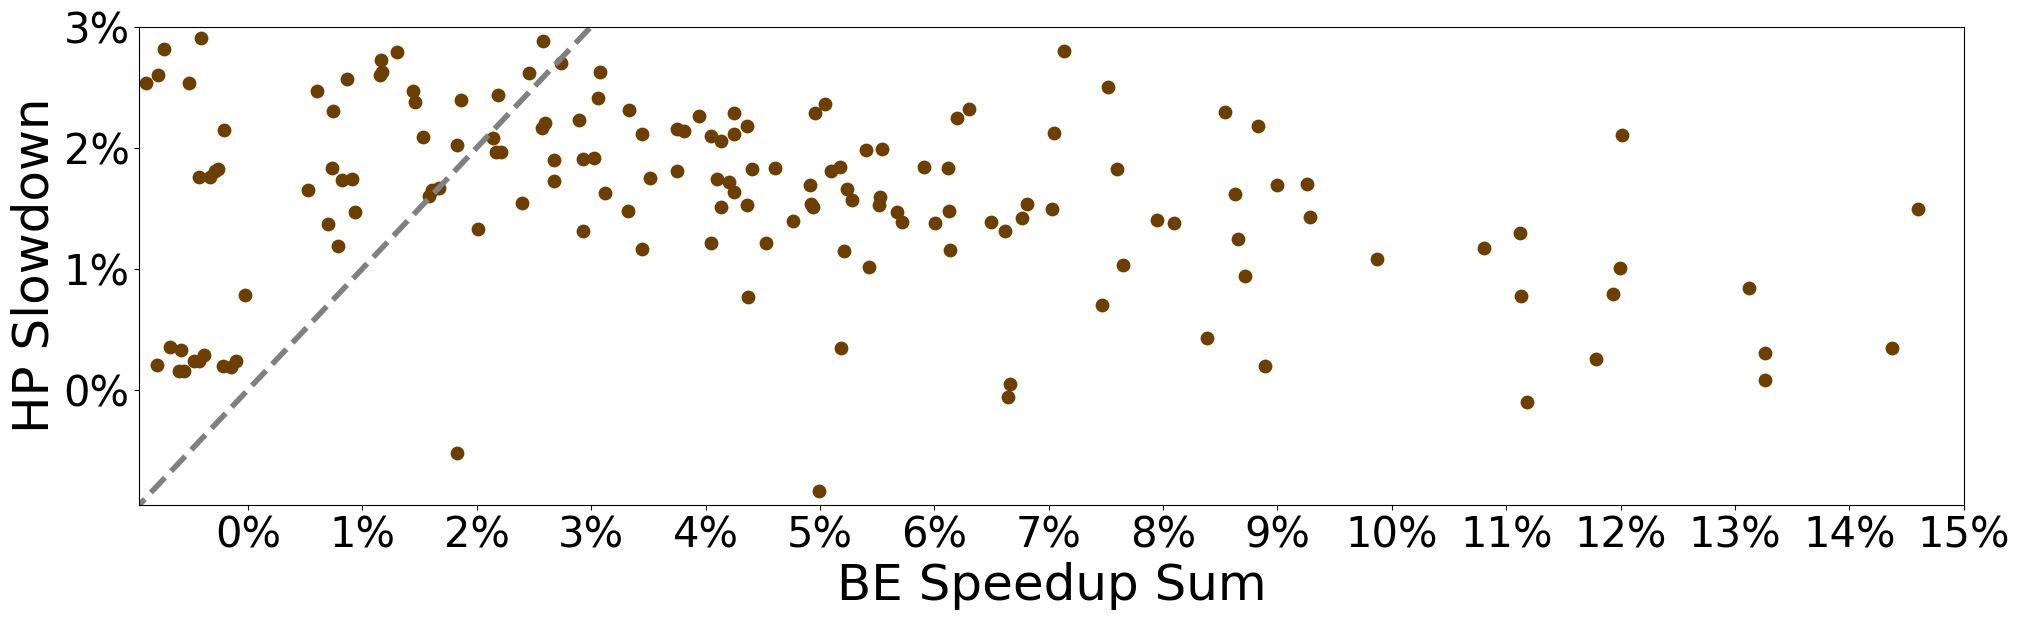

In [89]:

from mpl_toolkits.mplot3d import Axes3D

# sheet32 = all_sheets['64bucket']
sheet32 = all_sheets[select_bucket]

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]

data = []

hp_datas = sheet32[exps[0]].to_numpy()
hp_datas = 1 - hp_datas

be_datas = [ sheet32[ke] for ke in exps[1:] ]

be_nps = [ b.to_numpy()  for b in be_datas]
be_nps = np.array(be_nps)
be_nps = be_nps - 1

sum_be = np.sum(be_nps, axis=0)
best_be = np.max(be_nps, axis=0)

# extend hp array 3 time 
hp_3_datas = np.tile(hp_datas, 3)

# extend sum array 3 times
sum_all_be = np.concatenate([sum_be, sum_be, sum_be], axis=0)

overall_be = np.concatenate(be_nps, axis=0)

print(overall_be.shape)
print(sum_all_be.shape)

sum_throughput = np.subtract(sum_be, hp_datas)

# Start with a square Figure.
fig, ax = plt.subplots(figsize=fig_inchs)
ax.set_xlim(-0.0095, 0.15)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.01))

ax.set_ylim(-0.0095, 0.03)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))

ax.set_xlabel('BE Speedup Sum')
ax.set_ylabel('HP Slowdown')

#add line for y=x
ax.add_line(Line2D([-1, 1], [-1, 1], color='gray',linewidth=4, linestyle='--'))

#set xtick fontsize
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(20)
# #set ytick fontsize
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(20)


# ax.scatter(overall_be, hp_3_datas,
ax.scatter(sum_be, hp_datas,
        s=80,
        c=contrasting_orange[11])
        # c=sum_throughput,
        # cmap='viridis_r')
        # cmap='summer_r')
fig.tight_layout(pad=0)

# # set legend
# legends = [Patch(color=contrasting_orange[i],label=f'{app_labels[i]}')
#                     for i in range(2)]
# # legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
# #             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
# #             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
# # plt.title(exps[0])

# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_scatter_pair_overall_97.png', dpi=300)

maxmin of overlap sumBE
0.2155625031802748
-0.24074848063474064
maxmin of overlap hp
0.18524382443767184
-0.01422603590380489


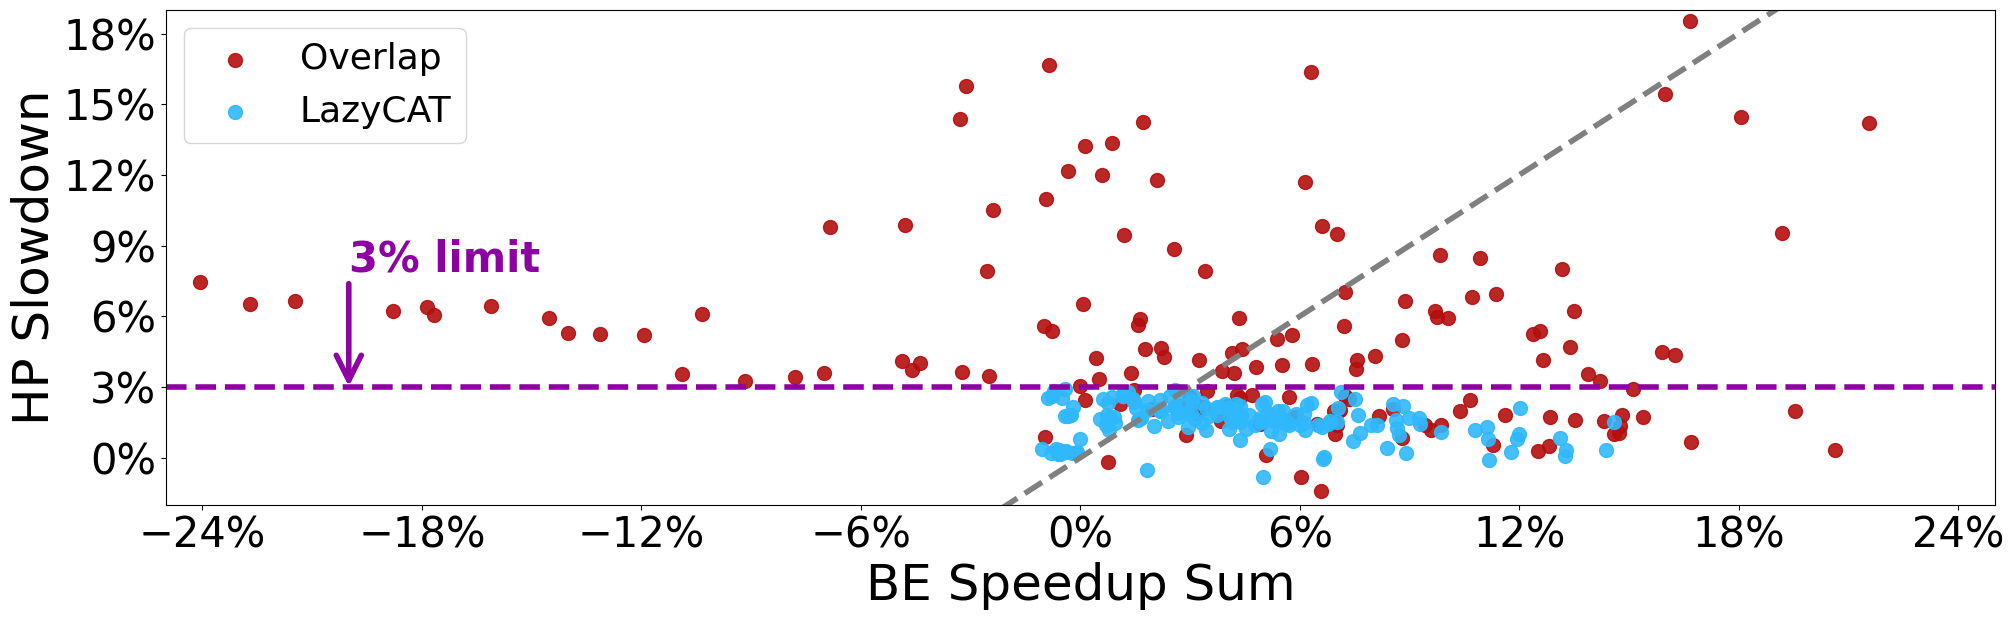

In [19]:
# sheet32 = all_sheets['64bucket']
sheet32 = all_sheets[select_bucket]

gsheet32 = sheet32.groupby('workload0')

expf = 'realOneWithTarget{}_speedup{}'
# compare cpu0 and other cpus
exps = [expf.format('0.97', i) for i in range(ncore)]
overl_f = 'OverlapOne_speedup{}'

overl_exps = [overl_f.format(corei) for corei in range(ncore)]

def get_speedups(exps,sheet):
    hp_datas = sheet[exps[0]].to_numpy()
    hp_datas = 1 - hp_datas

    be_datas = [ sheet[ke] for ke in exps[1:] ]

    be_nps = [ b.to_numpy()  for b in be_datas]
    be_nps = np.array(be_nps)
    be_nps = be_nps - 1
    sum_be = np.sum(be_nps, axis=0)

    return hp_datas, sum_be

lazy_hp_datas, lazy_sum_be = get_speedups(exps, sheet32)
overl_hp_datas, overl_sum_be = get_speedups(overl_exps, sheet32)

print("maxmin of overlap sumBE")
print(np.max(overl_sum_be))
print(np.min(overl_sum_be))
print("maxmin of overlap hp")
print(np.max(overl_hp_datas))
print(np.min(overl_hp_datas))

# Start with a square Figure.
fig, ax = plt.subplots(figsize=fig_inchs)
ax.set_xlim(-0.25, 0.25)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.06))

ax.set_ylim(-0.02, 0.19)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.03))

ax.set_xlabel('BE Speedup Sum')
ax.set_ylabel('HP Slowdown')

#add line for y=x
ax.add_line(Line2D([-1, 1], [-1, 1], color='gray',linewidth=4, linestyle='--'))

ax.axhline(y=0.03, color='#8D00A1',linewidth=4, linestyle='--')
ax.annotate( '', xy=(-0.20, 0.029), xytext=(-0.20, 0.075),
        arrowprops=dict(arrowstyle="->", linewidth=4 ,facecolor='#8D00A1',ec='#8D00A1') )
ax.annotate( '3% limit', xy=(-0.20, 0.075),color='#8D00A1',fontsize = 30,
                xytext=(-0.20, 0.075) , va = "bottom", ha="left" ,fontweight='bold')

#set xtick fontsize
# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(20)
# #set ytick fontsize
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(20)


# ax.scatter(overall_be, hp_3_datas,
ax.scatter(overl_sum_be, overl_hp_datas,
        s=100,alpha=0.9,
        c=contrasting_orange[4],
        label='Overlap')
ax.scatter(lazy_sum_be, lazy_hp_datas,
        s=100,alpha=0.9,
        c=contrasting_orange[5],
        label='LazyCAT')
# ax.grid(True)

fig.tight_layout(pad=0)

# # set legend
# legends = [Patch(color=contrasting_orange[i],label=f'{app_labels[i]}')
#                     for i in range(2)]
# # legends = [ Line2D([0], [0], color=colors[0], lw=2, label='16 Buckets'),
# #             Line2D([0], [0], color=colors[1], lw=2, label='32 Buckets'),
# #             Line2D([0], [0], color=colors[2], lw=2, label='64 Buckets')]
# plt.legend(handles = legends)
plt.legend()
# # plt.title(exps[0])

# plt.show()
plt.savefig(f'{pic_dir_path}/asplos23_mix{ncore}_scatter_overlap_compare_97.png', dpi=300)